# "Pyro에서 독립 차원 선언: plate"
> "plate를 이용하여 데이터의 각 사례(example)는 독립적이라고 선언한다."

- toc: true
- badges: true
- author: 단호진
- categories: [ppl]

시계열 데이터가 아닌 데이터 셋의 각 사례(example)를 생각해보자. 그 사례는 어떤 파라미터를 가진 확률 변수의 실현값이라고 생각할 수 있다. 고정된 파라미터라고 해도 확률 과정이므로 표본 사례의 값은 서로 다를 수 있다. 한편 사례와 사례의 차이는 파라이터의 차이에서도 나올 수 있다. 데이터의 사례뿐만 아니라 숨은 변수가 숨은 확률 변수들의 결합 확률 분포를 따르는 상황도 있을 수 있다. 어는 경우든 데이터의 독립성을 선언해야 할 필요가 생긴다. 이 포스트에서는 plate 컨텍스트를 이용하여 데이터의 각 사례가 독립적이라고 선언하는 방법을 정리해 보겠다. 

[Pyro의 확률적 통계 추론 입문](https://pyro.ai/examples/svi_part_i.html) 튜토리얼의 동전 편형성 문제를 plate를 사용하여 재 구성해보겠다.

## 동전 편향 문제

동전을 열번 던져서 앞면이 7회 나왔다고 할 때 빈도주의에서는 p=0.5로 가정하고 분석을 진행한다. 이항 분포를 따른다고 할 때 관측의 확률은 $\binom{10}{3} \frac{1}{2^{10}} =  0.117$이다. 3개보다 더 적게 나오거나 7개 이상 나오는 경우를 따져보면 다음과 같다.

In [1]:
from math import comb
from functools import reduce

pr = map(lambda k: comb(10, k) / 2 ** 10, [0, 1, 2, 3])
pr = reduce(lambda a, x: a + x, pr) * 2  # two-tail
pr

0.34375

빈도주의 관점에서 p=0.5라는 것을 기각하기 어렵다. 베이즈 통계라면 관측 데이터에서 최선의 p를 추정해 보고자 한다. 사전 분포를 B(15.0, 15.0)인 베타 함수로 정의하여 p=0.5 중심에서 약간의 편향이 존재할 수 있다고 보았다. 관측 데이터를 얻은 후 사후 분포를 pyro로 구해 보자.

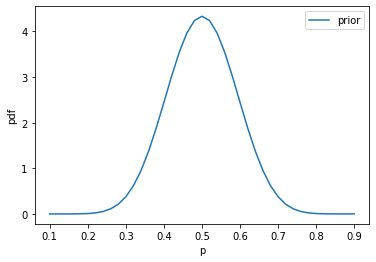

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.stats import beta
import matplotlib.pyplot as plt

def plot(a, b, ax):
    rv = beta(a, b)
    p = np.linspace(0.1, 0.9, 41)
    df = pd.DataFrame(dict(p=p, pdf=rv.pdf(p)))
    return sns.lineplot(x='p', y='pdf', data=df, ax=ax)

fig, ax = plt.subplots()
a, b = 15.0, 15.0
ax = plot(a, b, ax)
ax.legend(['prior']);

In [3]:
import torch
from torch.distributions import constraints
import pyro
import pyro.distributions as dist

pyro.enable_validation(True)

## ELBO

ELBO(Evidence Lower BOund)의 최소화 하고자 한다. $ELBO \equiv \mathbb{E}_{q_{\phi} (z)} [\log p_{\theta} (x, z) - \log q_{\phi} (z)]$ 식으로 주어 진다면 $\log p_{\theta} (x, z)$는 model 함수에서 $\log q_{\phi} (z)$는 guide 함수를 통해서 구하게 된다. 배경 이론에 대해서는 [Pyro의 확률적 통계 추론 입문](https://pyro.ai/examples/svi_part_i.html) 튜토리얼을 참고하자. pyro.sample 함수가 정의되면 내부적으로 log_prob 함수를 통하여 로그 확률을 평가하게 된다.

이 문제에서 guide에 베이즈 분석의 사전 분포를 정의하였다. 알고자 하는 분포의 근사로 생각해도 좋다. 

## 데이터

In [4]:
data = [1.0] * 7 + [0.0] * 3
data = torch.tensor(data)
data

tensor([1., 1., 1., 1., 1., 1., 1., 0., 0., 0.])

## 모델

model1 + guide1은 숨은 확률 변수 z에서 하나의 값을 실현하고 그 값에 대하여 관측치를 평가한다. 동일 동전으로 10번의 동전 던지기를 수행했다고 볼 수 있다.

In [5]:
def guide1(data):
    alpha_q = pyro.param(
        'alpha_q', torch.tensor(15.0), constraint=constraints.positive)
    beta_q = pyro.param(
        'beta_q', torch.tensor(15.0), constraint=constraints.positive)
    pyro.sample('z', dist.Beta(alpha_q, beta_q))  # shape: []

    
def model1(data):
    alpha0 = torch.tensor(10.0)
    beta0 = torch.tensor(10.0)
    z = pyro.sample('z', dist.Beta(alpha0, beta0))
    with pyro.plate('data', len(data)):
        pyro.sample(
            'obs',
            dist.Bernoulli(z),
            obs=data)

model2 + guide2는 모든 관측치에 다른 z의 실현 값을 가지고 관측치를 평가한다. 각 관측은 독립이고, 동일 동전이라도 던질 때마다 환경이 조금씩 변경되어 확률도 달라진다고 보는 것이다. plate 컨텍스트에서 0차 텐서는 len(data) 크기를 갖도록 변경된다. model2 + guide2의 z에는 크기 len(data)의 실현 값이 들어간다.

## 훈련

In [6]:
import numpy as np

svi = pyro.infer.SVI(
    model1, guide1, pyro.optim.Adam({'lr': 0.0005}), pyro.infer.Trace_ELBO())

steps = 2000
for step in range(steps):
    l = svi.step(data)
    if step % 100 == 0:
        alpha_q, beta_q = pyro.param('alpha_q').item(), pyro.param('beta_q').item()
        print(f'loss: {l:.2f}, alpha_q: {alpha_q:.2f}, beta_q: {beta_q:.2f}')
        
inferred_mean = alpha_q / (alpha_q + beta_q)
# compute inferred standard deviation
factor = beta_q / (alpha_q * (1.0 + alpha_q + beta_q))
inferred_std = inferred_mean * np.sqrt(factor)

print("\nbased on the data and our prior belief, the fairness " +
      "of the coin is %.3f +- %.3f" % (inferred_mean, inferred_std))

loss: 6.84, alpha_q: 15.01, beta_q: 14.99
loss: 7.22, alpha_q: 15.38, beta_q: 14.60
loss: 7.12, alpha_q: 15.75, beta_q: 14.21
loss: 6.91, alpha_q: 15.99, beta_q: 13.95
loss: 7.20, alpha_q: 16.12, beta_q: 13.85
loss: 7.20, alpha_q: 16.24, beta_q: 13.74
loss: 7.13, alpha_q: 16.43, beta_q: 13.56
loss: 6.90, alpha_q: 16.58, beta_q: 13.45
loss: 6.84, alpha_q: 16.58, beta_q: 13.47
loss: 6.79, alpha_q: 16.65, beta_q: 13.41
loss: 6.75, alpha_q: 16.71, beta_q: 13.33
loss: 6.84, alpha_q: 16.71, beta_q: 13.32
loss: 6.80, alpha_q: 16.88, beta_q: 13.18
loss: 6.90, alpha_q: 16.94, beta_q: 13.15
loss: 6.89, alpha_q: 16.92, beta_q: 13.15
loss: 6.87, alpha_q: 17.02, beta_q: 13.05
loss: 6.86, alpha_q: 17.07, beta_q: 13.00
loss: 6.85, alpha_q: 16.99, beta_q: 13.06
loss: 6.88, alpha_q: 16.90, beta_q: 13.11
loss: 6.85, alpha_q: 16.99, beta_q: 13.04

based on the data and our prior belief, the fairness of the coin is 0.566 +- 0.089


## 사후 분포

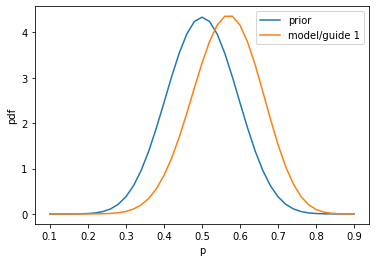

In [7]:
fig, ax = plt.subplots()
ax = plot(15.0, 15.0, ax)
a, b = pyro.param('alpha_q').item(), pyro.param('beta_q').item()
ax = plot(a, b, ax)
ax.legend(['prior', 'model/guide 1']);

* 사후 분포가 사전 분포에서 관측에 의한 p=7/10 방향으로 이동하였다.
* MAP로 동전의 편향을 점추정하거나 범위를 추정할 수 있다.
* 추가로 동전 던지기를 한다면 새로운 prior로 이 모델을 이용할 수도 있다.